# Supervised drift detection on the penguins dataset

## Method

When true outputs/labels are available, we can perform supervised drift detection; monitoring the model's performance directly in order to check for harmful drift. Two detectors ideal for this application are the [Fisher’s Exact Test (FET) detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/fetdrift.html) and [Cramér-von Mises (CVM) detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/cvmdrift.html) detectors.

The FET detector is designed for use on binary data, such as the instance level performance indicators from a classifier (i.e. 0/1 for each incorrect/correct classification). The CVM detector is designed use on continuous data, such as a regressor's instance level loss or error scores.

In this example we will use the offline versions of these detectors, which are suitable for use on batches of data. In many cases data may arrive sequentially, and the user may wish to perform drift detection as the data arrives to ensure it is detected as soon as possible. In this case, the online versions of the [FET](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/onlinefetdrift.html) and [CVM](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/onlinecvmdrift.html) detectors can be used, as will be explored in a future example.



## Dataset

The [palmerpenguins](https://allisonhorst.github.io/palmerpenguins) dataset <cite data-cite="Horst2020"><!-- --></cite> consists of data on 344 penguins from 3 islands in the Palmer Archipelago, Antarctica. There are 3 different species of penguin in the dataset, and a common task is to classify the the species of each penguin based upon two features, the length and depth of the peguin's bill, or beak.

<div>
<img src="image/penguins.png" width="700"/>
</div>

<div>
<img src="image/penguinculmen.png" width="600"/>
</div>

Artwork by [Allison Horst](https://twitter.com/allison_horst)

This notebook requires the `seaborn` package for visualization and the `palmerpenguins` package to load data. Thse can be installed via `pip`:

In [ ]:
!pip install palmerpenguins
!pip install seaborn

In [11]:
from functools import partial
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns 

# construct cmap
sns.set_style('whitegrid')
sns.set(font_scale = 1.2)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from alibi_detect.cd import MMDDrift, FETDrift, CVMDrift

# Set color pallette to match palmerpenguins
mypalette = sns.color_palette(["#ff7300","#008b8b", "#c15bcb"], as_cmap=True)
sns.set_palette(mypalette)
my_cmap = ListedColormap(mypalette)

## Load data

To download the dataset we use the [palmerpenguins](https://github.com/mcnakhaee/palmerpenguins) package:

In [12]:
from palmerpenguins import load_penguins

In [13]:
data = load_penguins().dropna()
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


The data consists of 333 rows (one row is removed as contains a NaN), one for each penguin. There are 8 features describing the peguins' physical characteristics, their species and sex, the island each resides on, and the year measurements were taken.

## Classification example

For our first example use case, we will perform the popular species classification task. Here we wish the classify the `species` based on only `bill_length_mm` and `bill_depth_mm`. To start we remove the other features and visualise those that remain.

In [7]:
data = data.drop(['island', 'flipper_length_mm', 'body_mass_g', 'sex', 'year'], axis=1)
y = data['species']

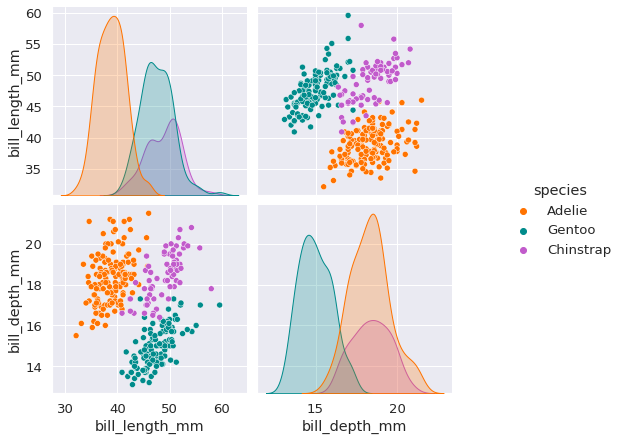

In [5]:
pairplot_figure = sns.pairplot(data, hue='species')
pairplot_figure.fig.set_size_inches(9, 6.5)

The above plot shows that the Adeilie species can primarily be identified by looking at bill length. Then to further distinguish between Gentoo and Chinstrap, we can look at the bill depth.

Next we separate the data into inputs and outputs, and encoder the species data to integers. Finally, we now split into three data sets; one to train the classifier, one to act a reference set when testing for drift, and one to test for drift on.

In [14]:
X = data[['bill_length_mm', 'bill_depth_mm']]
y = data['species']
mymap = {'Adelie':0, 'Gentoo':1, 'Chinstrap':2}
y = y.map(mymap)

X_train, X_ref, y_train, y_ref = train_test_split(X.to_numpy(), y.to_numpy(), train_size=60, random_state=42)
X_ref, X_test, y_ref, y_test = train_test_split(X_ref, y_ref, train_size=0.5, random_state=42)

### Train a classifier

For this dataset, a relatively shallow decision tree classifier should be sufficient, and so we train an `sklearn` one on the training data.

In [34]:
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf = clf.fit(X_train, y_train)

In [35]:
print('Training accuracy = %.1f %%' % (100*clf.score(X_train, y_train)))
print('Test accuracy = %.1f %%' % (100*clf.score(X_test, y_test)))

Training accuracy = 100.0 %
Test accuracy = 88.3 %


As expected, the decision tree is able to give acceptable classification accuracy on the train and test sets.

### Shift data

In order to demonstrate use of the drift detectors, we first need to add some artificial drift to the test data `X_test`. We add two types of drift here; to create covariate drift we subtract 5mm from the bill length of all the Gentoo penguins. $P(y|\mathbf{X})$ is unchanged here, but clearly we have introduced a delta $\Delta P(\mathbf{X})$. To create concept drift, we switch the labels of the Gentoo and Chinstrap penguins, so that the underlying process $P(y|\mathbf{X})$ is changed.

In [41]:
X_covar, y_covar = X_test.copy(), y_test.copy()
X_concept, y_concept = X_test.copy(), y_test.copy()

# Apply covariate drift by altering the bill depth of the Gentoo species
idx1 = np.argwhere(y_test==1)
X_covar[idx1,1] -= 5

# Apply concept drift by switching two species
idx2 = np.argwhere(y_test==2)
y_concept[idx1] = 2
y_concept[idx2] = 1

Xs = {'No drift': X_test, 'Covariate drift': X_covar, 'Concept drift': X_concept}

We now define a utility function to plot the classifier's decision boundaries, and we use this to visualise the reference data set, the test set, and the two new data sets where drift is present.

In [39]:
def plot_decision_boundaries(X, y, clf, ax=None, title=None):
    """
    Helper function to visualize a classifier's decision boundaries. 
    """
    if ax is None:
        f, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlabel('Bill length (mm)')
    ax.set_ylabel('Bill Depth (mm)')
    
    # Plotting decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.2, cmap=my_cmap)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolor="k", cmap=my_cmap)
    
    ax.text(0.02, 0.98, 'Model accuracy = %.1f %%' % (100*clf.score(X, y)),
           ha='left', va='top', transform=ax.transAxes, fontweight='bold')
    
    if title is not None:
        ax.set_title(title)

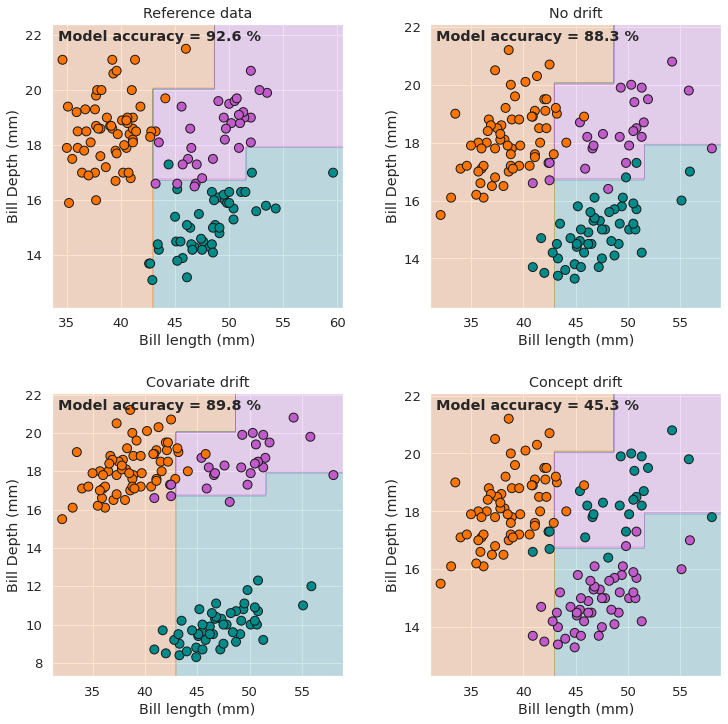

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
plot_decision_boundaries(X_ref, y_ref, clf, ax=axs[0,0], title='Reference data')
plot_decision_boundaries(X_test, y_test, clf, ax=axs[0,1], title='No drift')
plot_decision_boundaries(X_covar, y_covar, clf, ax=axs[1,0], title='Covariate drift')
plot_decision_boundaries(X_concept, y_concept, clf, ax=axs[1,1], title='Concept drift')
plt.subplots_adjust(wspace=0.3, hspace=0.3)

These plots serve as a visualisation of the differences between covariate drift and concept drift. Importantly, the model accuracies shown above also highlight the fact that not all drift is necessarily malicious, in the sense that even relatively significant drift does not always lead to degradation in a model's performance indicators. For example, the model actually gives a slightly higher accuracy on the *covariate drift* data set than on the *no drift* set in this case. Conversely, the *concept drift* unsuprisingly leads to severely degraded model performance.

### Unsupervised drift detection

Before getting to the main task in this example, monitoring malicious drift with a supervised drift detector, we will first use the [MMD detector](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/mmddrift.html) to check for covariate drift. To do this we initialise it in an unsupervised manner by passing it the input data `X_ref`.

In [44]:
cd_mmd = MMDDrift(X_ref, p_val = 0.05)

Applying this detector on the *no drift*, *covariate drift* and *concept drift* data sets, we see that the detector only detects drift in the *covariate drift* case. Not detecting drift in the *no drift* case is desirable, but not detecting drift in the *concept drift* case is potentially problematic.

In [45]:
labels = ['No!', 'Yes!']
for name, Xarr in Xs.items():
    print('\n%s' % name)
    np.random.seed(0)  # Set the seed used in the MMD permutation test (only for notebook reproducibility)
    preds = cd_mmd.predict(Xarr)
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('p-value: {}'.format(preds['data']['p_val']))


No drift
Drift? No!
p-value: 0.37

Covariate drift
Drift? Yes!
p-value: 0.0

Concept drift
Drift? No!
p-value: 0.37


### Supervised drift detection

The fact that the unsupervised detector above does not detect the severe *concept drift* demonstrates the motivation for using supervised drift detectors that directly check for malicious drift, which can include malicious concept drift.

To perform supervised drift detection we first need to compute the model's performance indicators. Since this is a classification task, a suitable performance indicator is the instance level binary losses, which are computed below.

In [47]:
loss_ref = (clf.predict(X_ref) == y_ref).astype(int)
loss_test = (clf.predict(X_test) == y_test).astype(int)
loss_covar = (clf.predict(X_covar) == y_covar).astype(int)
loss_concept = (clf.predict(X_concept) == y_concept).astype(int)
losses = {'No drift': loss_test, 'Covariate drift': loss_covar, 'Concept drift': loss_concept}

print(loss_ref)

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


As seen above, these losses are binary data, where 0 represents an incorrect classification for each instance, and 1 represents a correct classification. 

Since this is binary data, the FET detector is chosen, and initialised on the reference loss data. The `alternative` hypothesis is set to `less`, meaning we will only flag drift if the proportion of 1s to 0s is reduced compared to the reference data. In other words, we only flag drift if the model's performance has degraded. 

In [48]:
cd_fet = FETDrift(loss_ref, p_val=0.05, alternative='less')

Applying this detector to the same three data sets, we see that malicious drift isn't detected in the *no drift* or *covariate drift* cases, which is unsurprising since the model performance isn't degraded in these cases. However, with this supervised detector, we now detect the malicious *concept drift* as desired.

In [51]:
labels = ['No!', 'Yes!']
for name, loss_arr in losses.items():
    print('\n%s' % name)
    preds = cd_fet.predict(loss_arr)
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('p-value: {}'.format(preds['data']['p_val'][0]))


No drift
Drift? No!
p-value: 0.15596677330906383

Covariate drift
Drift? No!
p-value: 0.2672809517932724

Concept drift
Drift? Yes!
p-value: 1.6510876695574494e-18


## Regression example

To provide a short example of supervised detection in a regression setting, we now rework the dataset into a regression task, and use the [CVM](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/cvmdrift.html) detector on the model's squared error.

Warning: Must have scipy >= 1.7.0 installed for this example.

### Load data and train model

For a regression task, we take the penguins' flipper length and sex as inputs, and aim to predict the penguins' body mass. Looking at a scatter plot of these features, we can see there is substantial correlation between the chosen inputs and outputs.

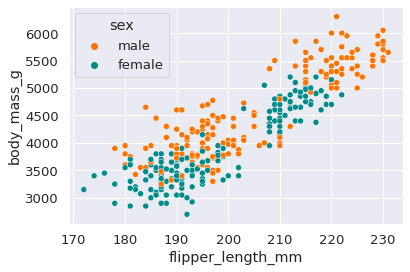

In [55]:
data_r = load_penguins().dropna()
Xr = data_r[['flipper_length_mm', 'sex']].replace({'sex': {'female': 1, 'male': 0}})
yr = data_r['body_mass_g']

_ = sns.scatterplot(data=data_r, x='flipper_length_mm', y='body_mass_g', hue='sex')

Again, we split the dataset into the same three sets; a training set, reference set and test set.

In [57]:
Xr_train, Xr_ref, yr_train, yr_ref = train_test_split(Xr.to_numpy(), yr.to_numpy(), 
                                                          train_size=60, random_state=42)
Xr_ref, Xr_test, yr_ref, yr_test = train_test_split(Xr_ref, yr_ref, train_size=0.5, random_state=42)

This time we train a linear regressor on the training data, and find that it gives acceptable training and test accuracy.

In [81]:
reg = LinearRegression()
reg.fit(Xr_train, yr_train)
print('Training RMS error = %.3f' % np.sqrt(np.mean((reg.predict(Xr_train)-yr_train)**2)))
print('Test RMS error = %.3f' % np.sqrt(np.mean((reg.predict(Xr_test)-yr_test)**2)))

Training RMS error = 397.805
Test RMS error = 378.418


### Shift data

To generate a copy of the test data with *concept drift* added, we use the model to create new output data, with a multiplicative factor and some Gaussian noise added. The quality of our synthetic output data is of course affected by the accuracy of the model, but it serves to demonstrate the behavior of the model (and detector) when $P(y|\mathbf{X})$ is changed.

In [87]:
Xr_concept = Xr_test.copy()
yr_concept = reg.predict(Xr_concept)*1.1 + np.random.normal(0, 100, size=len(yr_test))

Unsurprisingly, the *covariate drift* leads to degradation in the model accuracy.

In [88]:
reg.score(Xr_concept, yr_concept)
print('Test RMS error = %.3f' % np.sqrt(np.mean((reg.predict(Xr_concept)-yr_concept)**2)))

Test RMS error = 443.833


### Supervised drift detection

As in the classification example, in order to perform supervised drift detection we need to compute the models performance indicators. For this regression example, the instance level squared errors are used.

In [89]:
lossr_ref = (reg.predict(Xr_ref) - yr_ref)**2
lossr_test = (reg.predict(Xr_test) - yr_test)**2
lossr_concept = (reg.predict(Xr_concept) - yr_concept)**2

lossesr = {'No drift': lossr_test, 'Concept drift': lossr_concept}

The CVM detector is trained on the reference losses:

In [90]:
cd_cvm = CVMDrift(lossr_ref, p_val=0.05)

As desired, the CVM detector does not detect drift on the *no drift* data, but does on *covariate drift* data.

In [91]:
labels = ['No!', 'Yes!']
for name, loss_arr in lossesr.items():
    print('\n%s' % name)
    preds = cd_cvm.predict(loss_arr)
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('p-value: {}'.format(preds['data']['p_val'][0]))


No drift
Drift? No!
p-value: 0.3499942719936371

Concept drift
Drift? Yes!
p-value: 1.1659972987132505e-10
